# Template fits with distortion correction

I recently gave a review talk on template fits in CERN's PHYSTAT seminar, where I presented results from [our recent paper on this subject](https://inspirehep.net/literature/2512593). In the summary, I discussed on of the downsides of template fits: if the simulation does not match the experiment perfectly, one cannot easily adjust for these discrepancies, as one would do in a parametric fit. For example, if I fit a peak over a smooth background, and the peak location is slightly off in the simulation, a parametric fit would simply fit a different peak location and give a good fit, while a template fit with templates taken from simulation would give poor results.

We explore this on a toy example. We want to fit a peak over smooth background using templates. The sample which provides a template for the peak is distorted. Its mean is shifted and it also too narrow. We want to fit the yield of this peak under these conditions.

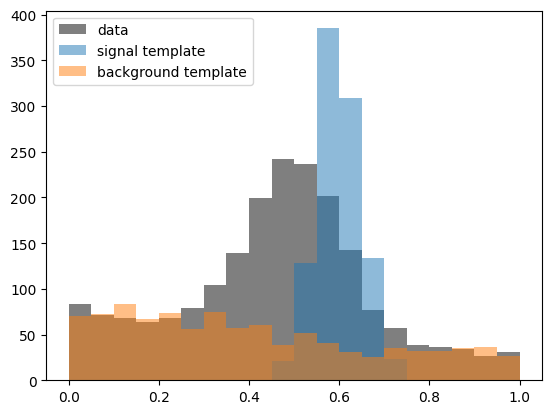

In [1]:
import numpy as np
from iminuit.cost import template_chi2_da
from iminuit import Minuit
from numba_stats import truncexpon, truncnorm
import matplotlib.pyplot as plt
from resample.bootstrap import resample
from scipy.optimize import differential_evolution
import warnings
from iminuit.warnings import IMinuitWarning

s_sample = truncnorm.rvs(0, 1, 0.5, 0.1, size=1000, random_state=1)
b_sample = truncexpon.rvs(0, 1, 0, 1, size=1000, random_state=1)
x_sample = np.append(s_sample, b_sample)

st_sample = truncnorm.rvs(0, 1, 0.6, 0.05, size=1000, random_state=2)
bt_sample = truncexpon.rvs(0, 1, 0, 1, size=1000, random_state=2)

n_data, xe, _ = plt.hist(
    x_sample, bins=20, range=(0, 1), alpha=0.5, color="k", label="data"
)
template_s = plt.hist(st_sample, bins=xe, alpha=0.5, label="signal template")[0]
template_b = plt.hist(bt_sample, bins=xe, alpha=0.5, label="background template")[0]
plt.legend();

In practice, this situation is common. The simulation is a good, but not perfect approximation of reality. Template fits could work very well in these situations if we find a way to fit a slightly distorted template instead of the raw one. For this to work, the distortion has to be a simple function, for example, an affine transformation like in this case. Then, the transformation can be fitted together with the yields. The parameters of the transformation are nuisance parameters. Note that the uncertainty of the fitted yield will always increase when such a transformation has to be estimated from the data as well.

## The catch

The idea to fit a transformed template is straight-forward, but there is a catch. Standard minimizers employed in HEP use a method based on gradient descent, and the gradient is computed numerically using a finite-difference formula. These minimizers only work correctly if the function to minimize is smooth: its first and second derivatives must be smoothly varying. But this is not the case the in the outlined approach, because the transformation will cause points from the samples that form the template to migrate from bin to bin. This causes jumps in the objective function and thus discontinuities in the derivatives. MINUIT does not like that at all. It can fail to converge, get stuck in a local minimum, or may report convergence to a point which is not a minimum. All of these outcomes are bad. The following cells demonstrate how MINUIT fails on such a fit. As objective function, we use the transformed approximate likelihood for template fits that we derived in our paper (implemented in `template_chi2_da`).

In [2]:
def model(s, b, offset, scale):
    mu_st_sample = np.mean(st_sample)
    st_sample_modified = scale * (st_sample - mu_st_sample) + mu_st_sample + offset
    template_s_modified = np.histogram(st_sample_modified, bins=xe)[0]
    # a small constant is added to avoid dividing by zero
    ts = template_s_modified / (np.sum(template_s_modified) + 1e-6)
    tb = template_b / np.sum(template_b)
    mu = s * ts + b * tb
    mu_var = s * ts**2 + b * tb**2
    return mu, mu_var


def objective(s, b, offset, scale):
    mu, mu_var = model(s, b, offset, scale)
    return template_chi2_da(n_data, mu, mu_var)


# if errordef and ndata on the objective are set,
# iminuit computes the chi2 gof test statistic for us
objective.errordef = Minuit.LEAST_SQUARES
objective.ndata = len(xe) - 1

m = Minuit(objective, s=1000, b=1000, offset=0, scale=1)
m.limits["s", "b"] = (0, None)
m.limits["scale"] = (0.01, 2.5)
m.limits["offset"] = (-0.2, 0.2)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 499 (χ²/ndof = 31.2)       │              Nfcn = 296              │
│ EDM = 2.72e-12 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s      │    494    │    33     │            │            │    0    │         │       │
│ 1 │ b      │  1.51e3   │  0.05e3   │            │            │    0    │         │       │
│ 2 │ offset │-9.0380e-3 │ 0.0033e-3 │            │            │  -0.2   │   0.2   │       │
│ 3 │ scale  │ 999.17e-3 │  0.31e-3  │            │            │  0.01   │   2.5   │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────┐
│        │            s            b       offset        scale │
├────────┼─────────────────────────────────────────────────────┤
│      s │     1.08e+03       -0.4e3 -2.648168e-6   -124.42e-6 │
│      b │       -0.4e3     2.02e+03  3.171095e-6    149.02e-6 │
│ offset │ -2.648168e-6  3.171095e-6     1.06e-11     0.497e-9 │
│  scale │   -124.42e-6    149.02e-6     0.497e-9     9.39e-08 │
└────────┴─────────────────────────────────────────────────────┘

MINUIT reports successful convergence, but signal and background yields are far from the truth. Also, the chi2/ndof ratio is far from 1. We can see that this a poor fit by drawing the fitted model and by looking at the profile-likelihood for each parameter.

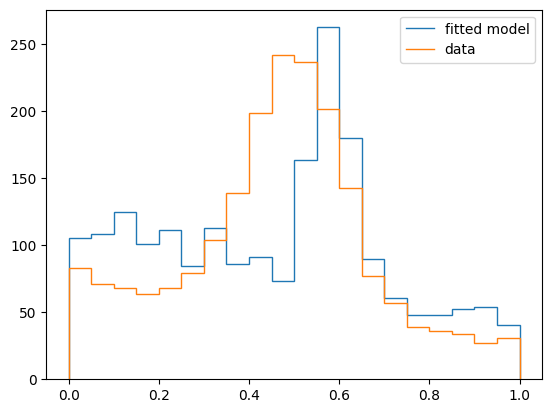

In [3]:
# let's draw the fitted model
plt.stairs(model(*m.values)[0], xe, label="fitted model")
plt.stairs(n_data, xe, label="data")
plt.legend();

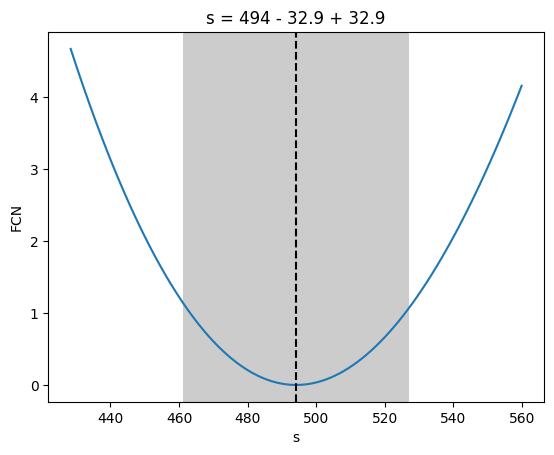

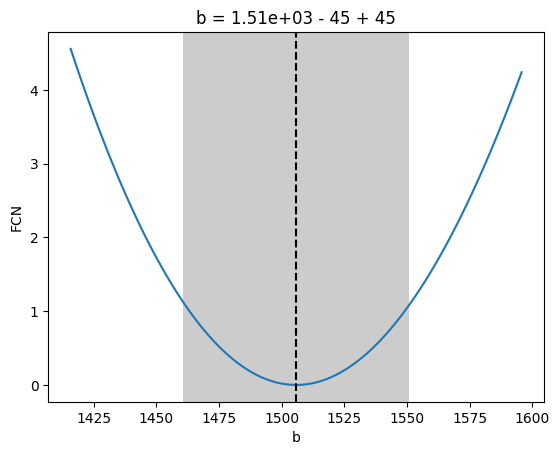

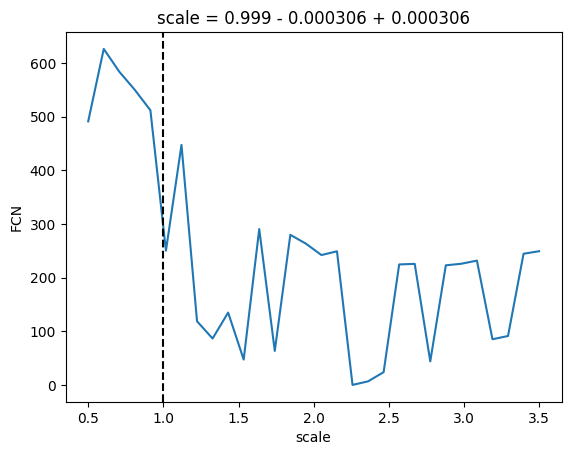

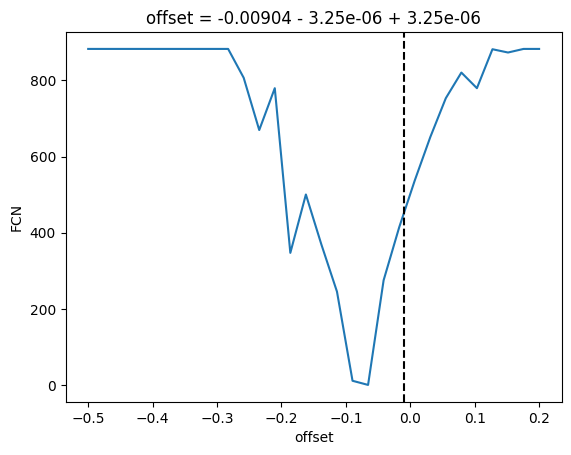

In [4]:
plt.figure()
m.draw_profile("s")
plt.figure()
m.draw_profile("b")
# ignore some iminuit warnings about failing to converge during profile computation
with warnings.catch_warnings():
    warnings.simplefilter("ignore", IMinuitWarning)
    plt.figure()
    m.draw_mnprofile("scale", bound=(0.5, 3.5))
    plt.figure()
    m.draw_mnprofile("offset", bound=(-0.5, 0.2))

We can see in the profile that we are not in the global minimum, which is near `offset = -0.1` and `scale = 2.2`.

## Solution

Two solutions come to mind, both have caveats.

### Use global derivative-free minimizer

This is the brute-force solution. If we cannot use a local minimizer which uses gradients, we should use a global derivative-free minimizer. Global derivative-free minimizers require many more function calls than the standard minimizers, and this number moreover scales quadratically with the number of fitted parameters. Fortunately, our objective function is relative fast to compute, and we do not have many fitted parameters, so global minimization is feasible. In the following, I apply the `differential_evolution` algorithm from `scipy` to this problem.

Optimization terminated successfully.
chi2/ndof = 1.0
s         = 1017
b         = 987
offset    = -0.09
scale     = 2.0


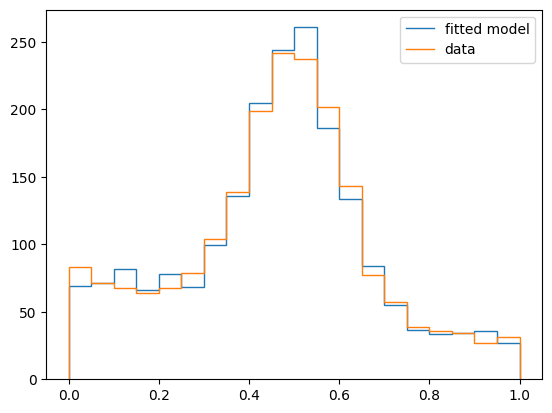

In [5]:
r = differential_evolution(
    lambda x: objective(*x),
    bounds=((0, 2000), (0, 2000), (-0.2, 0.2), (0.5, 3.5)),
    polish=False,
    seed=1,
)
print(r.message)

chi2 = objective(*r.x)

print(f"chi2/ndof = {chi2/(objective.ndata - m.nfit):.1f}")
print(f"s         = {r.x[0]:.0f}")
print(f"b         = {r.x[1]:.0f}")
print(f"offset    = {r.x[2]:.2f}")
print(f"scale     = {r.x[3]:.1f}")

# let's draw the fitted model
plt.stairs(model(*r.x)[0], xe, label="fitted model")
plt.stairs(n_data, xe, label="data")
plt.legend();

This looks great! We got an excellent chi2/ndof ratio and the fitted model agrees well with the data. Our idea works, and the global minimizer did not take too much time either.

Now we need to address the next challenge: we also want to know the parameter uncertainties. We cannot use the usual technique of inverting the appropriately scaled Hesse matrix of the objective function at the minimum to get the covariance matrix, because this would again require a numerical computation of second derivatives.

I will nevertheless attempt to compute the covariance matrix with Minuit's HESSE algorithm to see what happens.

In [6]:
m.values = r.x
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                               External                                  │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 15.5 (χ²/ndof = 1.0)       │             Nfcn = 9332              │
│ EDM = 0.0125 (Goal: 0.0002)      │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s      │  1.02e3   │  0.04e3   │            │            │    0    │         │       │
│ 1 │ b      │    990    │    40     │            │            │    0    │         │       │
│ 2 │ offset │ -87.39e-3 │  0.14e-3  │            │            │  -0.2   │   0.2   │       │
│ 3 │ scale  │  1.9848   │  0.0015   │            │            │  0.01   │   2.5   │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────┐
│        │          s          b     offset      scale │
├────────┼─────────────────────────────────────────────┤
│      s │   1.85e+03     -0.7e3   4.261e-6  -185.2e-6 │
│      b │     -0.7e3    1.7e+03 -28.018e-6  -217.3e-6 │
│ offset │   4.261e-6 -28.018e-6   2.08e-08   0.050e-6 │
│  scale │  -185.2e-6  -217.3e-6   0.050e-6   2.29e-06 │
└────────┴─────────────────────────────────────────────┘

HESSE reports succeess, but the uncertainties on offset and scale are suspiciously small. We should not trust this result. This is one of the possible outcomes if the second derivatives are not well-defined bad. In other cases, HESSE may fail or report that the covariance matrix had to be forced to be positive definite.

Since this does not work, we employ the bootstrap technique. We use the `resample` library. This library includes some functions which readily compute the covariance for a simple function in one line, but we have a more complicated case where it is not applicable. We need to resample three samples simultaneously, which have different sizes, the data sample and the two samples that generate the templates. We use the "extended" method to also vary the sizes of these samples, which is usually the correct thing in high-energy physics.

In [7]:
def fit(x_sample, st_sample, bt_sample):
    n_data = np.histogram(x_sample, bins=xe)[0]
    template_b = np.histogram(bt_sample, bins=xe)[0]

    def model(s, b, offset, scale):
        mu_st_sample = np.mean(st_sample)
        st_sample_modified = scale * (st_sample - mu_st_sample) + mu_st_sample + offset
        template_s_modified = np.histogram(st_sample_modified, bins=xe)[0]
        # a small constant is added to avoid dividing by zero
        ts = template_s_modified / (np.sum(template_s_modified) + 1e-6)
        tb = template_b / np.sum(template_b)
        mu = s * ts + b * tb
        mu_var = s * ts**2 + b * tb**2
        return mu, mu_var

    def objective(s, b, offset, scale):
        mu, mu_var = model(s, b, offset, scale)
        return template_chi2_da(n_data, mu, mu_var)

    r = differential_evolution(
        lambda x: objective(*x),
        bounds=((0, 2000), (0, 2000), (-0.2, 0.2), (0.5, 3.5)),
        polish=False,
        seed=1,
    )
    assert r.success
    return r.x


number_of_bootstrap_samples = 20
kwargs = {"size": number_of_bootstrap_samples, "method": "extended", "random_state": 1}

results = []
for xs, sts, bts in zip(
    resample(x_sample, **kwargs),
    resample(st_sample, **kwargs),
    resample(bt_sample, **kwargs),
):
    xb = fit(xs, sts, bts)
    results.append(xb)

cov = np.cov(results, rowvar=False)

for name, val, err in zip(m.parameters, r.x, np.diag(cov) ** 0.5):
    print(f"{name} = {val:.2f} +/- {err:.2f}")

s = 1016.88 +/- 71.60
b = 987.33 +/- 51.06
offset = -0.09 +/- 0.00
scale = 1.98 +/- 0.16


The calculation takes a while but eventually completes. We now find larger uncertainties compared to the HESSE estimate above, which essentially treated the transform like it was fixed. We can see that the increase in the uncertainties indeed originates from the fitted transform, if we repeat the bootstrap with fixed the transformation parameters.

In [8]:
def fit(x_sample, st_sample, bt_sample):
    n_data = np.histogram(x_sample, bins=xe)[0]
    template_b = np.histogram(bt_sample, bins=xe)[0]

    def model(s, b, offset, scale):
        mu_st_sample = np.mean(st_sample)
        st_sample_modified = scale * (st_sample - mu_st_sample) + mu_st_sample + offset
        template_s_modified = np.histogram(st_sample_modified, bins=xe)[0]
        # a small constant is added to avoid dividing by zero
        ts = template_s_modified / (np.sum(template_s_modified) + 1e-6)
        tb = template_b / np.sum(template_b)
        mu = s * ts + b * tb
        mu_var = s * ts**2 + b * tb**2
        return mu, mu_var

    def objective(s, b, offset, scale):
        mu, mu_var = model(s, b, offset, scale)
        return template_chi2_da(n_data, mu, mu_var)

    r = differential_evolution(
        lambda x: objective(*x, -0.09, 1.99), bounds=((0, 2000), (0, 2000)), 
        polish=False,
        seed=1
    )
    assert r.success
    return r.x


kwargs = {"size": number_of_bootstrap_samples, "method": "extended", "random_state": 1}

results = []
for xs, sts, bts in zip(
    resample(x_sample, **kwargs),
    resample(st_sample, **kwargs),
    resample(bt_sample, **kwargs),
):
    xb = fit(xs, sts, bts)
    results.append(xb)

cov = np.cov(results, rowvar=False)

for name, val, err in zip(m.parameters, r.x, np.diag(cov) ** 0.5):
    print(f"{name} = {val:.2f} +/- {err:.2f}")

s = 1016.88 +/- 50.19
b = 987.33 +/- 39.07
